In [1]:
%pylab inline
from classy import Class
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.special import spherical_jn, sici
from sympy.physics.wigner import wigner_3j

# Parameters
z = 0.57
h = 0.68
R_min = 20
R_max = 160
n_r = 10
LMAX = 4

Populating the interactive namespace from numpy and matplotlib


In [2]:
### Load matter power spectrum (for testing)
print("NEED TO ADD PROPER POWER SPECTRUM!")
cosmo = Class()
cosmo.set({'output':'mPk,mTk,tCl','z_pk':z,'h':h})
cosmo.compute()

k_arr = np.logspace(-4,2,10000)
pk_lin_arr = np.asarray([cosmo.pk_lin(kk*h,z)*h**3. for kk in k_arr])

# Load transfer functions
T_all = cosmo.get_transfer(z,'class')
kTk = T_all['k (h/Mpc)']
Tk = T_all['d_tot']
Tk_arr = interp1d(kTk,Tk)(k_arr)

# Compute interpolator for curvature power spectrum and transfer function
p_zeta = interp1d(k_arr,pk_lin_arr/Tk_arr**2.)
M = interp1d(k_arr,Tk_arr)

NEED TO ADD PROPER POWER SPECTRUM!


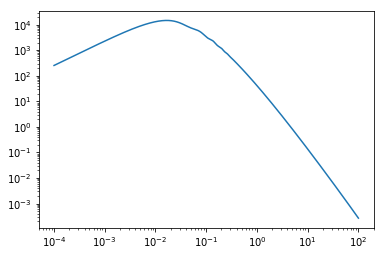

In [3]:
plt.loglog(k_arr,pk_lin_arr)

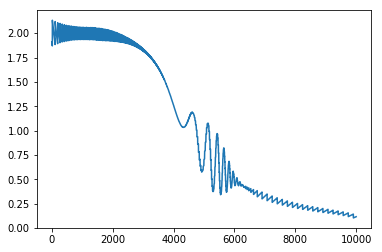

In [4]:
plt.plot(np.diff(np.log(-M(k_arr)))/np.diff(np.log(k_arr)))

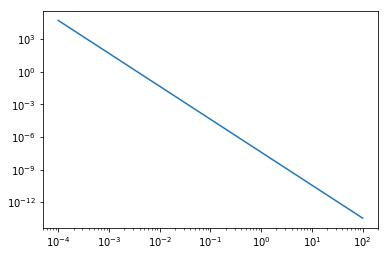

In [5]:
plt.loglog(k_arr,p_zeta(k_arr))

In [6]:
# Define arrays
s_arr = np.arange(0,250,0.1)[None,:]
x_arr = np.arange(0,250,0.1)
k_arr = np.arange(0.001,10,0.01)[:,None]

# Define bin-integrated Bessel functions
def integ_bessel(ell,bin1,k):
    r_min = bin1*(R_max-R_min)/n_r+R_min
    r_max = (bin1+1.)*(R_max-R_min)/n_r+R_min
    if ell==0:
        tmp1 = (-k*r_max*np.cos(k*r_max)+np.sin(k*r_max))/k**3. 
        tmp2 = (-k*r_min*np.cos(k*r_min)+np.sin(k*r_min))/k**3.
    elif ell==1:
        tmp1 = -2.*np.cos(k*r_max)/k**3. - r_max*np.sin(k*r_max)/k**2.
        tmp2 = -2.*np.cos(k*r_min)/k**3. - r_min*np.sin(k*r_min)/k**2.
    elif ell==2:
        tmp1 = (r_max*np.cos(k*r_max))/k**2 - (4*np.sin(k*r_max))/k**3 + (3*sici(k*r_max)[0])/k**3
        tmp2 = (r_min*np.cos(k*r_min))/k**2 - (4*np.sin(k*r_min))/k**3 + (3*sici(k*r_min)[0])/k**3
    elif ell==3:
        tmp1 = (7.*np.cos(k*r_max))/k**3 - (15.*np.sin(k*r_max))/(k**4*r_max) + (r_max*np.sin(k*r_max))/k**2
        # avoid zero errors!
        if r_min==0:
            tmp2 = -(8./k**3.)
        else:
            tmp2 = (7.*np.cos(k*r_min))/k**3 - (15.*np.sin(k*r_min))/(k**4*r_min) + (r_min*np.sin(k*r_min))/k**2
    elif ell==4:
        tmp1 = (105.*np.cos(k*r_max))/(2.*k**4*r_max) - (r_max*np.cos(k*r_max))/k**2 + (11*np.sin(k*r_max))/k**3 -(105*np.sin(k*r_max))/(2.*k**5*r_max**2) + (15*sici(k*r_max)[0])/(2.*k**3)
        if r_min==0:
            tmp2 = 0.
        else:
            tmp2 = (105.*np.cos(k*r_min))/(2.*k**4*r_min) - (r_min*np.cos(k*r_min))/k**2 + (11*np.sin(k*r_min))/k**3 -(105*np.sin(k*r_min))/(2.*k**5*r_min**2) + (15*sici(k*r_min)[0])/(2.*k**3)
    elif ell==5:
        tmp1 = ((315*k*r_max - 16*k**3*r_max**3)*np.cos(k*r_max) - (315 - 105*k**2*r_max**2 + k**4*r_max**4)*np.sin(k*r_max))/(k**6*r_max**3)
        if r_min==0:
            tmp2 = -16./k**3.
        else:
            tmp2 = ((315*k*r_min - 16*k**3*r_min**3)*np.cos(k*r_min) - (315 - 105*k**2*r_min**2 + k**4*r_min**4)*np.sin(k*r_min))/(k**6*r_min**3)
    else:
        raise Exception("not implemented yet!")
    return (tmp1-tmp2)/((r_max**3.-r_min**3.)/3.)

In [7]:
# Compute j_l(ks) posibilities
jl_ks = []
print("Computing j_ell(ks)")
for l in range(LMAX+1):
    jl_ks.append(spherical_jn(l,k_arr*s_arr))
    
# Compute j_ell(kr) possibilities
jell_kr = []
print("Computing j_ell(kr)")
for ell in range(LMAX+1):
    print("ell = %d"%ell)
    tmp_jell_kr = []
    for rbin in range(n_r):
        tmp_jell_kr.append(integ_bessel(ell,rbin,k_arr))
    jell_kr.append(tmp_jell_kr)
    
# Compute Mk, P_zeta(k)
Mk_arr = M(k_arr)
Pzeta_arr = p_zeta(k_arr)

Computing j_ell(ks)
Computing j_ell(kr)
ell = 0
ell = 1
ell = 2
ell = 3
ell = 4


In [8]:
from mcfit import P2xi, xi2P

In [129]:
from scipy.special import legendre

t_arr = np.logspace(-4,4,1001)[:,None]
mu_arr = np.linspace(-1,1,101)[None,:]
n = 1
ns = cosmo.n_s()

k12_integ = []
for l in range(LMAX+1):
    integrand = legendre(l)(mu_arr)*np.power(1.+2*mu_arr*t_arr+t_arr**2.,-0.5*(n+4-ns))
    ii = simps(integrand,mu_arr,axis=1)*(2.*l+1.)/2.
    k12_integ.append(interp1d(t_arr[:,0],ii))#,fill_value='extrapolate'))
    
def f_k12(k1,k2,l):
    return np.power(k1,n+4.-ns)*k12_integ[l](k2/k1)

/home/ophilcox/.conda/envs/ptenv/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


In [136]:
f_k12(1,0.9,0)

49.47419631645233

In [121]:
k1 = np.linspace(0.01,10,100)[:,None]
k2 = np.linspace(0.01,10,100)[None,:]
f12 = f_k12(k1,k2,1)

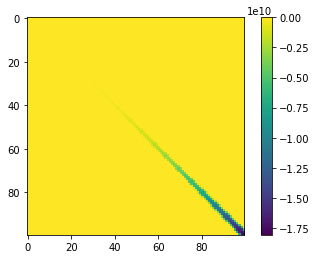

In [123]:
plt.imshow(f12);plt.colorbar();

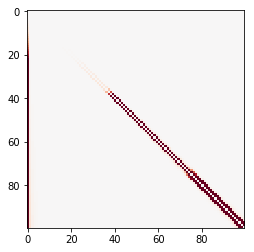

In [115]:
plt.imshow(f12/np.sqrt(np.outer(np.diag(f12),np.diag(f12)))-np.eye(len(f12)),vmax=0.1,vmin=-0.1,cmap=cm.RdBu_r)

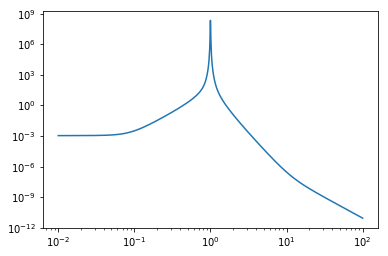

In [81]:
plt.loglog(t_arr,np.abs(ii));

In [222]:
x_arr = np.linspace(0.1,1000,101)[None,:,None]
xp_arr = np.linspace(0.1,1000,101)[None,None,:]
kk = np.logspace(-4,1,100)[:,None,None]
l = 4
lp = 4

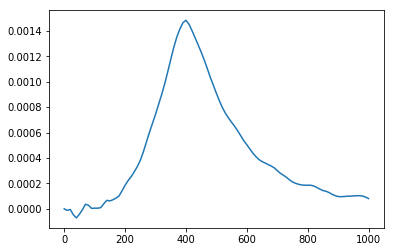

In [226]:
ns = cosmo.n_s()
#ss = simps(kk**(ns-4.)*kk**2./(2.*np.pi**2.)*spherical_jn(l,kk*x_arr)*spherical_jn(lp,kk*xp_arr),kk,axis=0)
ss = simps(kk**(ns-4.)*kk**2./(2.*np.pi**2.)*spherical_jn(l,kk*x_arr)*spherical_jn(lp,kk*xp_arr),kk,axis=0)
plt.plot(x_arr.ravel(),ss[:,40]);

In [190]:
kk = np.logspace(-6,2,1000)
pp = kk**(ns-4.-1.)
rr,xixi = P2xi(kk)(pp*(kk>1e-2))
kk0,pp02 = xi2P(rr)(xixi)

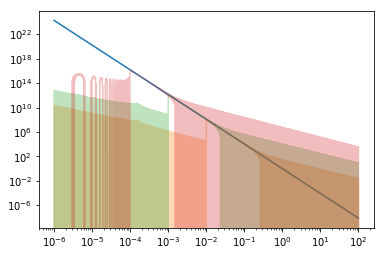

In [191]:
plt.loglog(kk,pp)
plt.loglog(kk0,pp02,alpha=0.3)
plt.loglog(kk0,pp03,alpha=0.3)
plt.loglog(kk0,pp04,alpha=0.3)
#plt.xlim([1,10000])

In [178]:
### Compute zeta_{-1} and zeta_{-2}
from mcfit import P2xi
kk = np.logspace(-4,1,1000)
zeta_neg1_int = interp1d(*P2xi(kk)(p_zeta(kk)))
zeta_neg2_int = interp1d(*P2xi(kk)(p_zeta(kk)/kk**2.))

ValueError: A value in x_new is below the interpolation range.

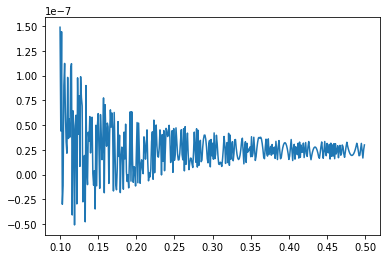

In [5]:
x_arr = np.arange(0.1,0.5,0.001)
plt.plot(x_arr,zeta_neg1_int(x_arr))
#plt.plot(x_arr,zeta_neg2_int(x_arr))

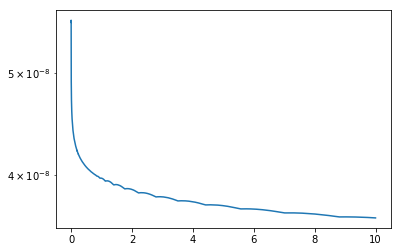

In [6]:
plt.plot(kk,p_zeta(kk)*kk**3.)
plt.yscale('log')

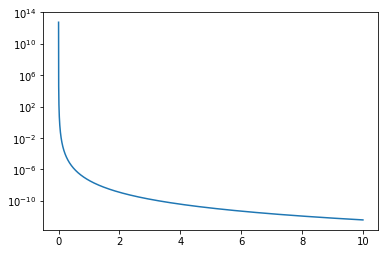

In [7]:
plt.plot(kk,p_zeta(kk)/kk**2);
plt.yscale('log')

#### Compute Q arrays

In [11]:
Mk = M(k_arr)

In [12]:
def compute_Q3(ell,l,rbin):
    return simps(k_arr**2.*jl_ks[l]*Mk*Pzeta_arr*jell_kr[ell][rbin],k_arr,axis=0)/(2.*np.pi**2.)*(-1.)**l

def compute_Q4(ell,l,rbin):
    return simps(k_arr**2.*jl_ks[l]*Mk*jell_kr[ell][rbin],k_arr,axis=0)/(2.*np.pi**2.)*(-1.)**l

In [13]:
# Compute all Q integrals
Q3 = []
Q4 = []

for rbin in range(n_r):
    print("On r-bin %d of %d"%(rbin+1,n_r))
    Q3ii = []
    Q4ii = []
    for ell in range(LMAX+1):
        Q3i = []
        Q4i = []
        for l in range(LMAX+1):
            Q3i.append(compute_Q3(ell,l,rbin))
            Q4i.append(compute_Q4(ell,l,rbin))
        Q3ii.append(Q3i)
        Q4ii.append(Q4ii)
    Q3.append(Q3ii)
    Q4.append(Q4ii)

On r-bin 0 of 10
On r-bin 1 of 10
On r-bin 2 of 10
On r-bin 3 of 10
On r-bin 4 of 10
On r-bin 5 of 10
On r-bin 6 of 10
On r-bin 7 of 10
On r-bin 8 of 10
On r-bin 9 of 10


In [ ]:
plt.plot(Q4[0][2][2])
plt.plot(Q4[1][1][6])